<a href="https://colab.research.google.com/github/EduFdezSoy/safety-first/blob/master/original_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Safety helmet detector

Source: https://www.kaggle.com/ehddnr301/helmet-classification

In [16]:
# Uncomment for install tensorflow 1.15.
!pip install tensorflow==1.15

In [17]:
# Imports
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
from skimage import io, transform
from PIL import Image

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D, Dropout
# Check Tensorflow version.
tf.version.VERSION

'1.15.0'

## 1. Loading Data

In [18]:
# Uncomment for clonning the repository
!git clone https://github.com/sergiorodenas/ml-data.git

fatal: destination path 'ml-data' already exists and is not an empty directory.


In [19]:
# Image constants
IMAGE_WIDTH=100
IMAGE_HEIGHT=100
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PATH1='./ml-data/helmet-dataset/Train_positive/Train_positive/'
PATH2='./ml-data/helmet-dataset/Train_negative/Train_negative/'

In [20]:
# Getting the images
filenames_list_yes = []
filenames_list_no = []

for filename in os.listdir(PATH1):
    filenames_list_yes.append(PATH1 + filename)
    
for filename in os.listdir(PATH2):
    filenames_list_no.append(PATH2 + filename)

df_yes = pd.DataFrame({
    'image': filenames_list_yes,
    'category': np.ones(len(filenames_list_yes), str)
})
df_no = pd.DataFrame({
    'image': filenames_list_no,
    'category': np.zeros(len(filenames_list_no), str)
})
print(df_yes.shape, df_no.shape)
df = df_yes.append(df_no, ignore_index=True)
print(df['image'][0])

(5160, 2) (6580, 2)
./ml-data/helmet-dataset/Train_positive/Train_positive/4325.jpg


## 2. Training data

In [21]:
# Hyperparameters
BATCH_SIZE=32
EPOCHS=20

In [22]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.15, stratify = df['category'], random_state = 3)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_valid = valid_df.shape[0]
print(train_df.shape)
print(valid_df.shape)

(9979, 2)
(1761, 2)


In [23]:
#We'll perform individually on train and validation set.
train_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   )

train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col = 'image',
                                              y_col = 'category',
                                              target_size = IMAGE_SIZE,
                                              batch_size = BATCH_SIZE,
                                              class_mode='binary',
                                              validate_filenames=False
                                             )

#we do not augment validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)
valid_gen = validation_datagen.flow_from_dataframe(
    valid_df, 
    x_col="image",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    validate_filenames=False
)

Found 9979 non-validated image filenames belonging to 2 classes.
Found 1761 non-validated image filenames belonging to 2 classes.


In [24]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(126, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(126, (3,3), activation='relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', 'Precision'])


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 49, 49, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 47, 47, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 45, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 64)       

## 3. Train the model

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath = 'mask.weights.best.hdf5', save_best_only = True, save_weights_only = True)
early_stop = EarlyStopping(monitor='loss', patience=3)
callbacks = [learning_rate_reduction, checkpointer, early_stop]

In [27]:
start = time.time()

model.fit_generator(train_gen,
                    epochs = EPOCHS,
                    validation_data = valid_gen,
                    validation_steps=total_valid//BATCH_SIZE,
                    steps_per_epoch=total_train//BATCH_SIZE,
                    callbacks = callbacks)

endTime = time.time() - start
print("Total time: ", endTime, "seconds")

Epoch 1/20
311/311 [==============================] - 14s 44ms/step - loss: 0.2110 - acc: 0.9143 - precision_2: 0.9043 - val_loss: 0.1455 - val_acc: 0.9369 - val_precision_2: 0.9783
Epoch 2/20
311/311 [==============================] - 12s 39ms/step - loss: 0.1273 - acc: 0.9577 - precision_2: 0.9481 - val_loss: 0.1146 - val_acc: 0.9659 - val_precision_2: 0.9697
Epoch 3/20
311/311 [==============================] - 12s 39ms/step - loss: 0.1146 - acc: 0.9604 - precision_2: 0.9515 - val_loss: 0.1457 - val_acc: 0.9375 - val_precision_2: 0.8970
Epoch 4/20
311/311 [==============================] - 12s 39ms/step - loss: 0.0951 - acc: 0.9677 - precision_2: 0.9572 - val_loss: 0.0803 - val_acc: 0.9722 - val_precision_2: 0.9751
Epoch 5/20
311/311 [==============================] - 12s 39ms/step - loss: 0.0838 - acc: 0.9696 - precision_2: 0.9610 - val_loss: 0.0633 - val_acc: 0.9795 - val_precision_2: 0.9804
Epoch 6/20
311/311 [==============================] - 12s 39ms/step - loss: 0.0610 - acc: 

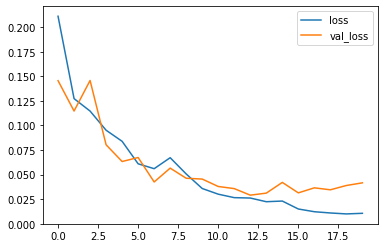

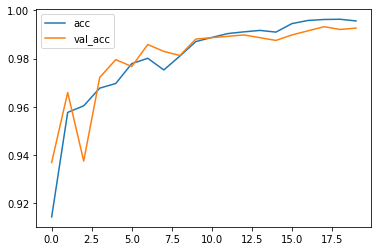

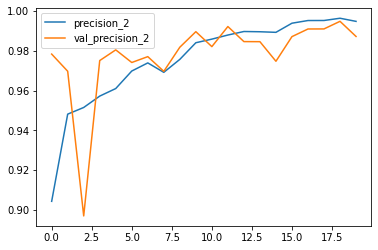

In [28]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['acc', 'val_acc']].plot()
loss[['precision_2', 'val_precision_2']].plot()

In [33]:
loss_mean = loss.mean()
loss_mean

loss               0.054444
acc                0.980105
precision_2        0.975613
val_loss           0.058292
val_acc            0.980483
val_precision_2    0.978088
lr                 0.000663
dtype: float64

In [30]:
print("Epochs: ", EPOCHS)
print("Train time: ", endTime, "seconds") 

Epochs:  20
Train time:  243.72427463531494 seconds


In [44]:
print("| ALGORITMO | {} | {} |  {} |   {} |  {} |      {} | {} |      {} |   {} |     |".format(loss_mean.acc, loss_mean.loss, loss_mean.val_acc, loss_mean.val_loss, loss_mean.precision_2, loss_mean.val_precision_2, loss_mean.lr, len(model.history.epoch), endTime))

| ALGORITMO | 0.9801045596599579 | 0.05444351230031882 |  0.9804829508066177 |   0.05829200801041597 |  0.975613358616829 |      0.9780876249074936 | 0.0006625000314670615 |      20 |   243.72427463531494 |     |
